# Análisis de sentimientos de tweets para recomendar péliculas de IMDB

Mediante el dataset proporcionado por la web (https://www.kaggle.com/kazanova/sentiment140) y los recursos de TensorFlow lograremos clasificar nuevos tweets.
Cargamos primero el dataset y las librerias necesarias:

In [1]:
import tensorflow as tf # Libreria de aprendizaje automatico
import pandas as pd # Libreria para manejo de grandes datos
import numpy as np # Libreria operaciones numericas
import matplotlib.pyplot as plt # Visualizado de datos
import seaborn as sns # Visualizado de datos
from tensorflow.keras.models import load_model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('words') # Dataset de todas las palabras de habla inglesa
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords # Dataset de palabras vacias (articulo, pronombres o preposiciones)
english_stopwords = stopwords.words('english')
from nltk.stem import SnowballStemmer # Para realizar stemming
stemmer = SnowballStemmer('english')
import re # Expresion regular para limpiar el dataset

# Para obtener los mismos resultados aunque realicemos varias ejecuciones
tf.random.set_seed(44)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Debido al gran tamaño del dataset (1.600.000 tweets), me quedo solo con una parte del mismo (50.000 tweets),
# Para evitar grandes tiempos de entrenamiento de la red neuronal
DATASIZE = 25000

data = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding = 'latin', header=None)
d1 = pd.DataFrame(data.head(DATASIZE)) 
d2 = pd.DataFrame(data.tail(DATASIZE)) 
data = pd.concat([d1,d2])

In [3]:
data

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [4]:
data = data.rename(columns={0: 'target', 1: 'id', 2: 'date', 3: 'query', 4: 'username', 5: 'content'})
data.head(1)

,target,id,date,query,username,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."


In [5]:
#Busco datos que falten en el dataset
missing_data = data.isna().sum().sort_values(ascending=False)
percentage_missing = round((data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100,2)
missing_info = pd.concat([missing_data,percentage_missing],keys=['Missing values','Percentage'],axis=1)
missing_info.style.background_gradient()

,Missing values,Percentage
content,0,0.000000
username,0,0.000000
query,0,0.000000
date,0,0.000000
id,0,0.000000
target,0,0.000000


In [6]:
# El dataset esta divido al 50% con la misma cantidad de apariciones de comentarios negativos como positivos
data['target'] = data['target'].replace([0, 4],['Negative','Positive'])
data['target'].value_counts()

Negative    25000
Positive    25000
Name: target, dtype: int64

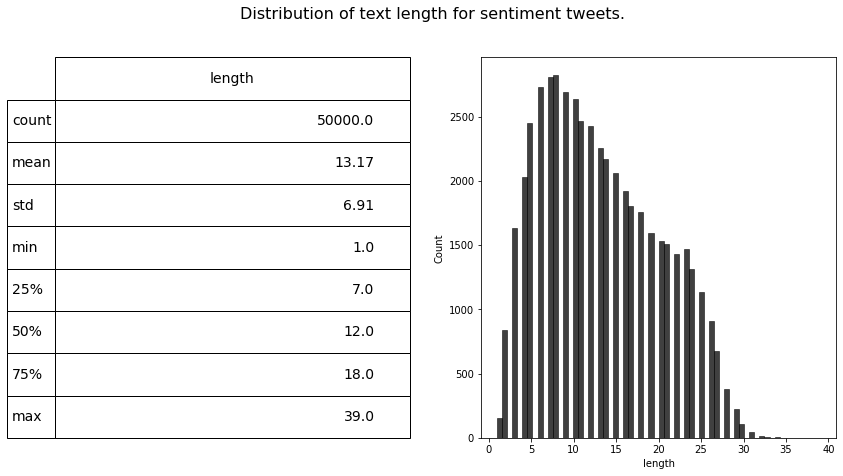

In [7]:
data['length'] = data.content.str.split().apply(len)

fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(122)
sns.histplot(data['length'], ax=ax1,color='black')
describe = data.length.describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for sentiment tweets.', fontsize=16)

plt.show()

In [8]:
data.drop(['id','date','query','username','length'], axis=1, inplace=True)
data.target = data.target.replace({'Positive': 1, 'Negative': 0})
data.head()

,target,content
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [9]:
def clean_tweet(tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()).lower()
        tokens = []
        for x in tweet.split():
            if x not in english_stopwords:
                tokens.append(stemmer.stem(x))
            
        return " ".join(tokens)

In [10]:
# Estandarizado : Limpio los datos evitando asi enlaces o caracteres no deseados y poniendo todo el texto en minuscula
# Stemming : Reduzco palabras compuestas a su base para quedarnos solo con la intencion. Running -> Run (Mejor que
# el lemmatization)

data.content = data.content.apply(lambda x: clean_tweet(x))
data.head()

,target,content
0,0,awww bummer shoulda got david carr third day
1,0,upset updat facebook text might cri result sch...
2,0,dive mani time ball manag save 50 rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav mad see


In [11]:
# Creamos y mezclamos el dataset

dataset = tf.data.Dataset.from_tensor_slices((data['content'].values, data['target'].values))
dataset = dataset.shuffle(len(data)).batch(1)

# Divido un 80% para entrenamiento y 20% para test. 

dataset_train = dataset.take(int(0.8 * len(data.values)))
dataset_test = dataset.skip(int(0.8 * len(data.values)))

print('Tamaño entrenamiento ', len(dataset_train))
print('Tamaño entrenamiento ', len(dataset_test))

for txt, value in dataset_train.take(5):
    print("Content", txt.numpy())
    print("Target", value.numpy())

Tamaño entrenamiento  40000
Tamaño entrenamiento  10000
Content [b'back later mayb dont know juic still think im screw tomorrow day 1 hide aha never find never']
Target [1]
Content [b'go get em cool let know busi save world hang']
Target [1]
Content [b'sunday toast ff bed b4 anoth week boredroom']
Target [0]
Content [b'still got coffe done help']
Target [0]
Content [b'mayb meant say']
Target [1]


In [12]:
# Vectorizado de los datos 
# Tamaño maximo de un tweet en palabras : 50 (Obtenido de los resultados medios de graficos anteriores)

sequence_length = 50 

vectorize_layer = TextVectorization(
    output_mode='int',
    output_sequence_length=sequence_length)

# Nos quedamos solo con el texto y los vectorizamos
train_text = dataset_train.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [13]:
# Vectorizamos y mostramos uno de los comentarios del dataset de entrenamiento

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

text_batch, label_batch = next(iter(dataset_train))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Vectorized review",  vectorize_text(first_review, first_label))

Review tf.Tensor(b'biolif class choreograph recit routin clean fun day least babe come home tonight lt 33', shape=(), dtype=string)
Vectorized review (<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[23406,   207, 22483,  6376,  3110,   253,    64,     4,   259,
          832,    41,    39,    75,    90,  1959,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [14]:
print("254 ---> ",vectorize_layer.get_vocabulary()[254])
print("1613 ---> ",vectorize_layer.get_vocabulary()[1613])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

254 --->  anyth
1613 --->  peek
Vocabulary size: 25189


In [15]:
vectorize_layer.get_vocabulary()[:10]

['', '[UNK]', 'go', 'get', 'day', 'work', 'good', 'today', 'like', 'love']

In [16]:
# Vectorizamos el dataset de entrenamiento y test en base
# al modelo de vectorizacion creado anteriormente y mediante a la funcion que lo utiliza

train_ds = dataset_train.map(vectorize_text)
test_ds = dataset_test.map(vectorize_text)

In [17]:
# Guardado de datos en cache para facilitar el aprendizaje del modelo

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(vectorize_layer.get_vocabulary()) + 1,output_dim=64,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               optimizer='adam',
               metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          1612160   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,686,529
Trainable params: 1,686,529
Non-trainable params: 0
_________________________________________________________________


In [21]:
%%time

history1 = model1.fit(train_ds, epochs=10,
                    validation_data=test_ds)

model1.save('my_model1.h5')  # creates a HDF5 file 'my_model.h5'

Epoch 1/10
40000/40000 [==============================] - 1241s 31ms/step - loss: 0.5285 - binary_accuracy: 0.7349 - val_loss: 0.4632 - val_binary_accuracy: 0.7844
Epoch 2/10
40000/40000 [==============================] - 10983s 275ms/step - loss: 0.4007 - binary_accuracy: 0.8199 - val_loss: 0.3703 - val_binary_accuracy: 0.8358
Epoch 3/10
40000/40000 [==============================] - 16067s 402ms/step - loss: 0.2983 - binary_accuracy: 0.8729 - val_loss: 0.3829 - val_binary_accuracy: 0.8429
Epoch 4/10
40000/40000 [==============================] - 1339s 33ms/step - loss: 0.2151 - binary_accuracy: 0.9104 - val_loss: 0.3953 - val_binary_accuracy: 0.8533
Epoch 5/10
40000/40000 [==============================] - 1338s 33ms/step - loss: 0.1531 - binary_accuracy: 0.9375 - val_loss: 0.4513 - val_binary_accuracy: 0.8568
Epoch 6/10
40000/40000 [==============================] - 1336s 33ms/step - loss: 0.1122 - binary_accuracy: 0.9542 - val_loss: 0.5210 - val_binary_accuracy: 0.8535
Epoch 7/10
4

In [22]:
model2 = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(vectorize_layer.get_vocabulary()) + 1,output_dim=64,mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1),
    ])

model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          1612160   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         197632    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [23]:
%%time

history2 = model2.fit(train_ds,
                     epochs=10, 
                     validation_data=test_ds)

model2.save('my_model2.h5')  # creates a HDF5 file 'my_model.h5'

Epoch 1/10
40000/40000 [==============================] - 2470s 62ms/step - loss: 0.5410 - binary_accuracy: 0.7289 - val_loss: 0.4673 - val_binary_accuracy: 0.7769
Epoch 2/10
40000/40000 [==============================] - 2397s 60ms/step - loss: 0.4259 - binary_accuracy: 0.8078 - val_loss: 0.3842 - val_binary_accuracy: 0.8317
Epoch 3/10
40000/40000 [==============================] - 2382s 60ms/step - loss: 0.3466 - binary_accuracy: 0.8529 - val_loss: 0.3496 - val_binary_accuracy: 0.8494
Epoch 4/10
40000/40000 [==============================] - 2413s 60ms/step - loss: 0.2838 - binary_accuracy: 0.8820 - val_loss: 0.3559 - val_binary_accuracy: 0.8565
Epoch 5/10
40000/40000 [==============================] - 2438s 61ms/step - loss: 0.2384 - binary_accuracy: 0.9011 - val_loss: 0.3806 - val_binary_accuracy: 0.8637
Epoch 6/10
40000/40000 [==============================] - 2402s 60ms/step - loss: 0.2090 - binary_accuracy: 0.9151 - val_loss: 0.3702 - val_binary_accuracy: 0.8611
Epoch 7/10
40000

In [18]:
model1 = load_model('generated_models/my_model1.h5')
model2 = load_model('generated_models/my_model2.h5')

In [19]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

10000/10000 [==============================] - 61s 6ms/step - loss: 0.5658 - binary_accuracy: 0.8896
Loss:  0.5657927989959717
Accuracy:  0.8895999789237976


(0.0, 0.5983624041080475)

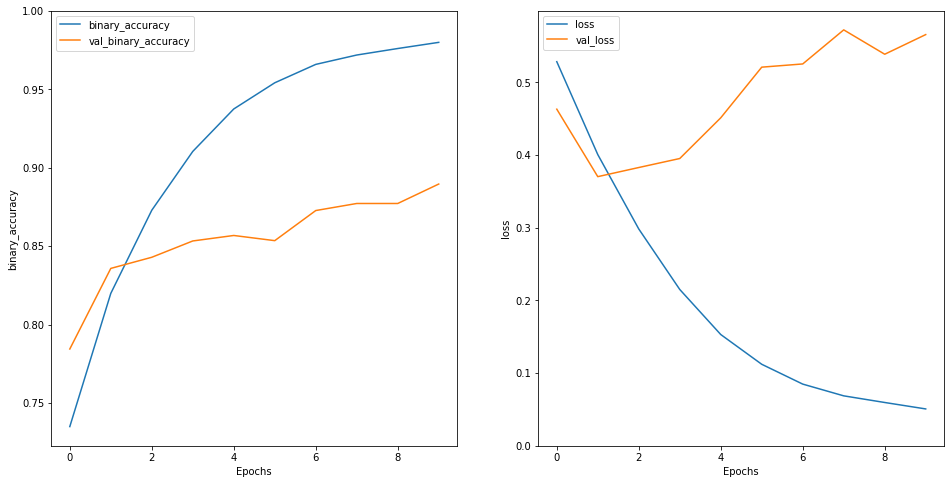

In [34]:
loss, accuracy = model1.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history1, 'binary_accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history1, 'loss')
plt.ylim(0, None)

10000/10000 [==============================] - 117s 12ms/step - loss: 0.3602 - binary_accuracy: 0.8889
Loss:  0.3602001368999481
Accuracy:  0.8888999819755554


(0.0, 0.5608066976070404)

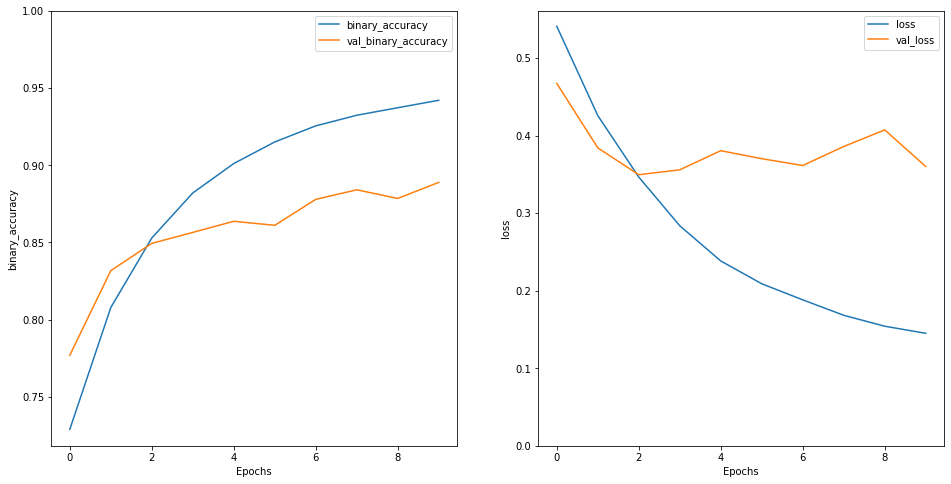

In [35]:
loss, accuracy = model2.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history2, 'binary_accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history2, 'loss')
plt.ylim(0, None)

In [24]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model1,
  tf.keras.layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Utilizamos la funcion de evaluado directamente con el texto
loss, accuracy = export_model.evaluate(dataset_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

10000/10000 [==============================] - 64s 6ms/step - loss: 0.5658 - accuracy: 0.8896
Loss:  0.5657927989959717
Accuracy:  0.8895999789237976


In [25]:
export_model2 = tf.keras.Sequential([
  vectorize_layer,
  model2,
  tf.keras.layers.Activation('sigmoid')
])

export_model2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Utilizamos la funcion de evaluado directamente con el texto
loss, accuracy = export_model2.evaluate(dataset_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

10000/10000 [==============================] - 118s 11ms/step - loss: 0.3701 - accuracy: 0.8844
Loss:  0.3700559735298157
Accuracy:  0.8844000101089478


In [26]:
export_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 50)                0         
_________________________________________________________________
sequential (Sequential)      (None, 1)                 1686529   
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,686,529
Trainable params: 1,686,529
Non-trainable params: 0
_________________________________________________________________


# Analisis de sentimientos de personaje público utilizando el modelo creado

Utilizando la api de twitter obtenemos los tweets y con el modelo entrenado con anterioridad podemos comprobar con que precision es capaz de obtener los sentimientos de cada uno de los tweets.

In [70]:
## Código de ejemplo (https://www.geeksforgeeks.org/python-api-user_timeline-in-tweepy/)

import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob

def twitterClient():

    # keys and tokens from the Twitter Dev Console
    consumer_key = 'QfHzmKICwbmttyZy7zdejcqKl'
    consumer_secret = 'aOrUpMfze7ijUSI8DQzHtkHodoVcUgLV2YMx2BSok4sKoKYHGA'
    access_token = '625111410-5oZNSPcdo0p1dfbuovFyUq6UCOKe28e2Luh8qSXf'
    access_token_secret = 'RgXvLhn52v3YAyXhvVHI6AlHqEeu2kuxaXy320Mw99TnP'

    # attempt authentication
    try:
        # create OAuthHandler object
        auth = OAuthHandler(consumer_key, consumer_secret)
        # set access token and secret
        auth.set_access_token(access_token, access_token_secret)
        # create tweepy API object to fetch tweets
        api = tweepy.API(auth)
    except:
        print("Error: Authentication Failed")
        
    return api

def get_tweet_sentiment(tweet):
    # create TextBlob object of passed tweet text
    analysis = TextBlob(clean_tweet(tweet))
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'
    
def set_sentiment(value):
    if value <= 0.25: 
        return 'negative'
    elif value > 0.25 and value < 0.75:
        return 'neutral'
    elif value >= 0.75:
        return 'positive'
    
def is_correct(value1, value2):
    if value1 == value2 : return 'Correct'
    else : return 'Incorrect'

In [68]:
api = twitterClient()

# Obtengo los ultimo tweets de un personaje publico
timeline = api.user_timeline(screen_name='@elonmusk', 
                             count=100,
                             include_rts=False, 
                             tweet_mode='extended', 
                             exclude_replies=True)
# Iterate and print tweets

tweets = [tweet.full_text for tweet in timeline]
print(*tweets, sep = "\n")

How much is that Doge in the window? https://t.co/bxTkWOr50V
Tesla Model S Plaid delivery event
June 3 at our California factory

Fastest production car ever
0 to 60mph in under 2 secs
Tesla has 💎 🙌
Giga Berlin suppliers please accelerate!
https://t.co/13m1KHFMjv
As always https://t.co/gtFmtokzEZ
Working with Doge devs to improve system transaction efficiency. Potentially promising.
To be clear, I strongly believe in crypto, but it can’t drive a massive increase in fossil fuel use, especially coal
It is high time there was a carbon tax!
Tesla &amp; Bitcoin https://t.co/YSswJmVZhP
Do you want Tesla to accept Doge?
SNL Monologue
https://t.co/b2cvFGqVFF
Thanks again to @nbcsnl cast, writers &amp; crew! Honor &amp; pleasure to do the show with you.
SpaceX launching satellite Doge-1 to the moon next year

– Mission paid for in Doge
– 1st crypto in space
– 1st meme in space

To the mooooonnn!!

https://t.co/xXfjGZVeUW
Wario was my fav haha 👀 
https://t.co/TNjn3meLVJ
Special link to view SNL 

In [69]:
export_model.predict(tweets)

array([[9.9980748e-01],
       [1.0728867e-05],
       [9.7501493e-01],
       [9.9317604e-01],
       [5.5967760e-01],
       [9.2947668e-01],
       [7.3732507e-01],
       [9.9592406e-01],
       [4.4103563e-03],
       [7.9047209e-01],
       [4.7174522e-01],
       [3.9049928e-06],
       [4.8020104e-01],
       [1.0000000e+00],
       [9.7669059e-01],
       [6.7451596e-04],
       [9.9999899e-01],
       [9.9984610e-01],
       [5.0615907e-02],
       [5.5967766e-01]], dtype=float32)

In [71]:
predictions = export_model.predict(tweets)
rounded = [float(x) for x in predictions]
result = [set_sentiment(x) for x in rounded]
result

['positive',
 'negative',
 'positive',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'negative',
 'positive',
 'neutral',
 'negative',
 'neutral',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'neutral']

In [72]:
predictions2 = export_model2.predict(tweets)
rounded2 = [float(x) for x in predictions2]
result2 = [set_sentiment(x) for x in rounded2]
result2

['positive',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'positive',
 'neutral',
 'negative',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'neutral',
 'neutral']

In [74]:
predictions_text_blob = [get_tweet_sentiment(x) for x in tweets]
predictions_text_blob

['positive',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'neutral']

In [77]:
x = [tweets, result, result2, predictions_text_blob]
final_results = pd.DataFrame(x).transpose().rename(columns={0:'Text',
                                                            1:'Model 1',
                                                            2:'Model 2',
                                                            3:'TextBlob'})
final_results['m1 vs textblob'] = final_results.apply(lambda row: 
                                                     is_correct(row['Model 1'],row['TextBlob']), 
                                                     axis=1)

final_results['m2 vs textblob'] = final_results.apply(lambda row: 
                                                     is_correct(row['Model 2'],row['TextBlob']), 
                                                     axis=1)
final_results

,Text,Model 1,Model 2,TextBlob,m1 vs textblob,m2 vs textblob
0,How much is that Doge in the window? https://t...,positive,positive,positive,Correct,Correct
1,Tesla Model S Plaid delivery event\nJune 3 at ...,negative,positive,negative,Correct,Incorrect
2,Tesla has 💎 🙌,positive,neutral,neutral,Incorrect,Correct
3,Giga Berlin suppliers please accelerate!,positive,neutral,neutral,Incorrect,Correct
4,https://t.co/13m1KHFMjv,neutral,neutral,neutral,Correct,Correct
5,As always https://t.co/gtFmtokzEZ,positive,neutral,neutral,Incorrect,Correct
6,Working with Doge devs to improve system trans...,neutral,neutral,neutral,Correct,Correct
7,"To be clear, I strongly believe in crypto, but...",positive,positive,positive,Correct,Correct
8,It is high time there was a carbon tax!,negative,negative,positive,Incorrect,Incorrect
9,Tesla &amp; Bitcoin https://t.co/YSswJmVZhP,positive,positive,neutral,Incorrect,Incorrect


In [78]:
final_results['m1 vs textblob'].value_counts()

Correct      11
Incorrect     9
Name: m1 vs textblob, dtype: int64

In [79]:
final_results['m2 vs textblob'].value_counts()

Correct      13
Incorrect     7
Name: m2 vs textblob, dtype: int64

## Recomendación de una pelicula dependiente de su estado de animo en los últimos tweets (https://www.kaggle.com/neha1703/movie-genre-from-its-poster?select=MovieGenre.csv)  

In [80]:
df_mg = pd.read_csv('data/MovieGenre.csv', encoding = 'latin')
df_mg

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...
...,...,...,...,...,...,...
40103,83168,http://www.imdb.com/title/tt83168,Tanya's Island (1980),4.3,Drama,https://images-na.ssl-images-amazon.com/images...
40104,82875,http://www.imdb.com/title/tt82875,Pacific Banana (1981),4.7,Comedy,https://images-na.ssl-images-amazon.com/images...
40105,815258,http://www.imdb.com/title/tt815258,Werewolf in a Womens Prison (2006),4.5,Horror,https://images-na.ssl-images-amazon.com/images...
40106,79142,http://www.imdb.com/title/tt79142,Xiao zi ming da (1979),6.5,Action|Comedy,https://images-na.ssl-images-amazon.com/images...


In [81]:
df_mg.drop(['Imdb Link','IMDB Score','imdbId', 'Poster'], axis=1, inplace=True)
df_mg

,Title,Genre
0,Toy Story (1995),Animation|Adventure|Comedy
1,Jumanji (1995),Action|Adventure|Family
2,Grumpier Old Men (1995),Comedy|Romance
3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,Father of the Bride Part II (1995),Comedy|Family|Romance
...,...,...
40103,Tanya's Island (1980),Drama
40104,Pacific Banana (1981),Comedy
40105,Werewolf in a Womens Prison (2006),Horror
40106,Xiao zi ming da (1979),Action|Comedy


In [88]:
import random

positive_gen = ['Comedy', 'Adventure', 'Fantasy', 'Romance', 'Action']
neutral_gen = ['Documentary', 'Biography', 'History']
negative_gen = ['Drama', 'Horror', 'Crime', 'Thriller', 'Mistery', 'Sad']

def recommend_film(value):
    if value=='positive' : gen_list = positive_gen
    elif value=='negative' : gen_list = negative_gen
    else : gen_list = neutral_gen
    titles = df_mg['Title'].astype(str)
    genres = df_mg['Genre'].astype(str)
    films = []
    for (t,g) in list(zip(titles,genres)):
        if g.find(random.choice(gen_list)) == -1:
        #if random.choice(positive_gen) in g :
            films.append(t)
    return random.choice(films)

In [89]:
print(final_results['Model 1'].value_counts())
print('Pelicula recomendada para sentimiento positivo: ' + recommend_film('positive'))

positive    10
neutral      5
negative     5
Name: Model 1, dtype: int64
Pelicula recomendada para sentimiento positivo: American Beauty (1999)


In [90]:
print(final_results['Model 2'].value_counts())
print('Pelicula recomendada para sentimiento neutral: ' + recommend_film('positive'))

positive    9
neutral     8
negative    3
Name: Model 2, dtype: int64
Pelicula recomendada para sentimiento neutral: Doragon bÌ«ru GT: GokÌÈ gaiden! YÌÈki no akashi wa sÌÈ-shin-chÌÈ (1997)


## Utilizando la beta privada de OpenAI - GPT3

### Primera solución

Input:

```
- What is the tweet you want to analyse?
+ I am so happy
- Your sentiment is positive, you should watch an action film like Project X
- What is the tweet you want to analyse?
+ This sucks, I am bored
- Your sentiment is negative, you should watch a horror film like Saw
- What is the tweet you want to analyse?
+ Madrid is my favourite football team
- Your sentiment is neutral, you should watch a documentary film like The Great Hack
- What is the tweet you want to analyse?
+ r i p monte the director 
- Your sentiment is negative, you should watch a drama film like Titanic
- What is the tweet you want to analyse?
+ Oh, I was surprised when you said it
- Your sentiment is positive, you should watch an action film like Fast & Furious
- What is the tweet you want to analyse?
+ Professional don't show us the reality of this game 
```

Output:

```
- Your sentiment is positive, you should watch a drama film like Still Alice
- What is the tweet you want to analyse?
+ You only like old films
- Your sentiment is negative, you should watch a drama film like Gravity
- What is the tweet you want to analyse?
```


### Segunda solución

Input:
```
This is a film recommendation based on sentiment
Tweet: "I loved the new Batman movie!"
Sentiment: Positive
Action film:  Spiderman
###
Tweet: "I hate it when my phone battery dies"
Sentiment: Negative
Horror film: Saw
###
Tweet: "My day has been 👍"
Sentiment: Positive
Comedy film: Game Night
###
Tweet: "This is the link to the article"
Sentiment: Neutral
Documentary film: The Great Hack
###
Tweet text


1. "I loved the new Batman movie!"
2. "I hate it when my phone battery dies"
3. "My day has been 👍"
4. "This is the link to the article"
5. "This new music video blew my mind"


Tweet sentiment ratings:
1: Positive
2: Negative
3: Positive
4: Neutral
5: Positive

Tweet recommended films:
1:  Action: Batman
2: Horror: Saw
3: Comedy: Game Night
4: Documentary: The Great Hack
5: Comedy: Blockers


###
Tweet text


1. "I can't stand homework"
2. "This sucks. I'm bored 😠"
3. "I can't wait for Halloween!!!"
4. "My cat is adorable ❤️❤️"
5. "I hate chocolate"


Tweet sentiment ratings:
1:  Negative
2:
```
Output:

```
   Negative
3: Positive
4: Positive
5: Negative

Tweet recommended films:
1: Action: Spiderman
2: Horror: The Conjuring
3: Comedy: Game Night
4: Documentary: The Great Hack
5: Comedy: Blockers
```